In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import time

In [2]:
T0 = time.time()
LineReader = csv.reader(open('shuffled-full-set-hashed.csv'), delimiter=',', quotechar='|')
row_num = 0
# for row in LineReader:
#     if row_num> 100: continue
#     print("row",row[0], len(row[1].split()) )
# #     print("---------------------")
#     row_num+= 1
Rows = [(row[0],row[1].split()) for row in LineReader]
for i in range(3): print(Rows[i][0],len(Rows[i][1]))
# print("Rows[0]",Rows[0][:5])

('DELETION OF INTEREST', 465)
('RETURNED CHECK', 403)
('BILL', 185)


In [3]:
num = 40000
with open("row"+str(num)+".csv", 'w') as fd:
    spamwriter = csv.writer(fd,delimiter=',', quotechar='|')
    for row in Rows[:num]:
        spamwriter.writerow([row[0]," ".join(row[1])])  

In [4]:
print("Elapsed time", time.time() - T0)
# print("Rows[0]",Rows[0])

('Elapsed time', 8.29665994644165)


In [5]:
from collections import Counter
MyCounter = Counter([row[0] for row in Rows])
print(MyCounter)

Counter({'BILL': 18968, 'POLICY CHANGE': 10627, 'CANCELLATION NOTICE': 9731, 'BINDER': 8973, 'DELETION OF INTEREST': 4826, 'REINSTATEMENT NOTICE': 4368, 'DECLARATION': 968, 'CHANGE ENDORSEMENT': 889, 'RETURNED CHECK': 749, 'EXPIRATION NOTICE': 734, 'NON-RENEWAL NOTICE': 624, 'BILL BINDER': 289, 'INTENT TO CANCEL NOTICE': 229, 'APPLICATION': 229})


In [6]:
# N gram models
Vocabulary = set([])
num = 0
for row in Rows:
    Vocabulary.update(row[1])
    num += len(row[1])
num_dev = int(len(Rows)/10)
#Resouvoir sampling
# class Solution(object):
#     def __init__(self, rows):
#         self.__rows = rows 
#     def pick(self, k):
#         """
#         :type target: int
#         """
#         reservoir = -1
#         n = 0
#         for i in xrange(len(self.__nums)):
#             if self.__nums[i] == target: 
#                 if randint(1, n+1) == 1: reservoir = i  # succinct
#                 n += 1 # I do not think this is what it needs -- this is mathematics "if randint(1, n+1) == 1: reservoir = i" does not work
#         return reservoir
train_rows = Rows[:-num_dev]
dev_rows = Rows[-num_dev:]
print(len(Vocabulary), num/ len(Vocabulary))

(1037934, 20)


In [7]:
from collections import defaultdict
Rows_by_label_dict = defaultdict(list)
print(len(train_rows),len(dev_rows),len(Rows))
for row in train_rows: 
    Rows_by_label_dict[row[0]].append(row[1])
# print("Rows_by_label_dict",Rows_by_label_dict["BILL"])

(55984, 6220, 62204)


In [8]:
def train_words_lm(train_rows_certain_type, Vocabulary, order=3, add_k=1):
    lm = defaultdict(Counter)
    for row in train_rows_certain_type:
        pad = ["~"] * order
        data = pad + row
        for i in range(len(data)-order):
            history, char = tuple(data[i:i+order]), data[i+order]
            lm[history][char]+=1
#         del history
#         del char
#         del i
    def normalize(counter): # input is a dictionary
        s = float(sum(counter.values())) + add_k *len(counter)
        return [(c,(cnt+add_k)/s) for c,cnt in counter.items()]
    outlm = {hist:normalize(chars) for hist, chars in lm.items()}
    return outlm

def perplexity(lm, row):
    order = len(list(lm.keys())[0]) #yezheng: I think it should not be an argument
    pad = ["~"] * order
    data = pad + row 
    logPP = 0
    for i in range(len(data)-order):
        history, char = tuple(data[i:(i+order)]), data[i+order] 
        if history not in lm: logPP -= np.log2(len(lm))
        else:
            dict_temp = dict(lm[history])
            if char not in dict_temp: logPP -= np.log2(1.0/len(lm))
            else: logPP -= np.log2(dict_temp[char])
    return logPP

In [9]:
T0 = time.time()
lms_dict = {}
for label in Rows_by_label_dict.keys(): 
    lms_dict[label] = train_words_lm(Rows_by_label_dict[label], Vocabulary)
    print("Elapsed time", time.time() - T0,"(",label,")")

('Elapsed time', 58.65829014778137, '(', 'POLICY CHANGE', ')')
('Elapsed time', 80.41955518722534, '(', 'CANCELLATION NOTICE', ')')
('Elapsed time', 81.07855701446533, '(', 'BILL BINDER', ')')
('Elapsed time', 81.55914497375488, '(', 'CHANGE ENDORSEMENT', ')')
('Elapsed time', 81.8783130645752, '(', 'INTENT TO CANCEL NOTICE', ')')
('Elapsed time', 256.7435691356659, '(', 'BILL', ')')
('Elapsed time', 261.0466661453247, '(', 'REINSTATEMENT NOTICE', ')')
('Elapsed time', 262.08764910697937, '(', 'APPLICATION', ')')
('Elapsed time', 440.8315341472626, '(', 'BINDER', ')')
('Elapsed time', 442.97597002983093, '(', 'RETURNED CHECK', ')')
('Elapsed time', 444.6209571361542, '(', 'EXPIRATION NOTICE', ')')
('Elapsed time', 448.02473616600037, '(', 'DECLARATION', ')')
('Elapsed time', 448.9312551021576, '(', 'NON-RENEWAL NOTICE', ')')
('Elapsed time', 452.2891321182251, '(', 'DELETION OF INTEREST', ')')


In [10]:
T0 = time.time()
import operator
i =0
label_true = []
label_pred = []
for row in dev_rows:
    i+=1
#     print(i, row[0],len(row[1]))
    label_true.append(row[0])
    PP_return_dict = dict([(label, perplexity(lms_dict[label], row[1])) for label in Rows_by_label_dict.keys()])
#     print(i,PP_return_dict)
    label_pred.append(max(PP_return_dict.items(), key=operator.itemgetter(1))[0])
    if 0 == i% 1000: print("Elapsed time", time.time() - T0,"(",i,")")

('Elapsed time', 2713.1541378498077, '(', 1000, ')')
('Elapsed time', 5176.833751916885, '(', 2000, ')')
('Elapsed time', 7562.0552179813385, '(', 3000, ')')
('Elapsed time', 9884.043408870697, '(', 4000, ')')
('Elapsed time', 15948.576964855194, '(', 5000, ')')
('Elapsed time', 18425.91857600212, '(', 6000, ')')


In [11]:
# confusion matrix
import numpy as np
n_categories= len(Rows_by_label_dict.keys())
labelToIdx = dict( (l,i) for i,l in enumerate(Rows_by_label_dict.keys()))
confusion = np.zeros((n_categories, n_categories),dtype = np.float64)
for i in range(len(dev_rows)):
    confusion[ labelToIdx[label_true[i]] ][labelToIdx[label_pred[i]]] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

In [12]:
print(confusion)

[[5.67772512e-01 6.63507109e-03 9.47867299e-03 7.39336493e-02
  2.38862559e-01 5.02369668e-02 4.73933649e-03 3.79146919e-03
  1.89573460e-02 2.84360190e-03 1.89573460e-03 1.13744076e-02
  2.84360190e-03 6.63507109e-03]
 [9.21187308e-03 7.70726714e-01 0.00000000e+00 2.04708291e-03
  5.11770727e-02 9.00716479e-02 1.94472876e-02 0.00000000e+00
  2.04708291e-03 0.00000000e+00 1.02354145e-03 2.04708291e-03
  1.33060389e-02 3.88945752e-02]
 [0.00000000e+00 0.00000000e+00 4.76190476e-01 0.00000000e+00
  2.38095238e-01 2.85714286e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.64705882e-01 0.00000000e+00 0.00000000e+00 7.29411765e-01
  8.23529412e-02 1.17647059e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.17647059e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.33333333e-02 6.66666667e-02 0.00000000e+00 0.00000000e+00
  6.00000000e-01 1.66666667e-01 3.33333333e-02 0.00000000e+00


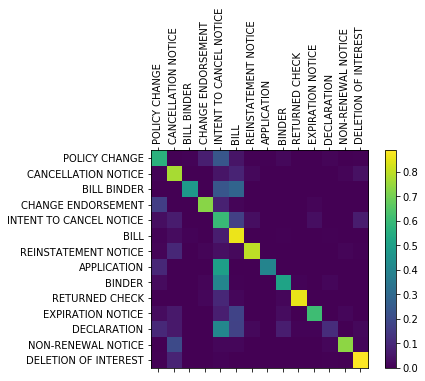

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(Rows_by_label_dict.keys()), rotation=90)
ax.set_yticklabels([''] + list(Rows_by_label_dict.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
# import dill                            #pip install dill --user
# filename = 'globalsave(order='+str(order)+', k='+str(k)+').pkl'
# dill.dump_session(filename)

# # and to load the session again:
# dill.load_session(filename)

fig.savefig('confusion.png')

In [ ]:
import pickle
fname = "lms_dict"
with open(fname + '.pkl', 'wb') as f:
        pickle.dump(lms_dict, f, pickle.HIGHEST_PROTOCOL)